<h2 id="download_data">Download Data</h2>


In [1]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

--2024-12-28 01:10:41--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  41.3MB/s    in 64s     

2024-12-28 01:11:45 (38.8 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [2]:
!unzip -q Positive_tensors.zip 

In [3]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2024-12-28 01:12:59--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  40.7MB/s    in 51s     

2024-12-28 01:13:50 (39.7 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



In [4]:
#!pip install torchvision

In [5]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


In [10]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        
        directory = os.getcwd()
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


In [11]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


In [12]:
# Step 1: Load the pre-trained model resnet18

model = models.resnet18(pretrained=True).to(device)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), transforms.Normalize(mean, std)])

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


In [13]:
# Step 2: Set the parameter cannot be trained for the pre-trained model
for param in model.parameters():
    param.requires_grad=False

In [14]:
# Replace the output layer model.fc of the neural network with a nn.Linear object, to classify 
# 2 different classes. For the parameters in_features remember the last hidden layer has 512 neurons.
model.fc=nn.Linear(512,2)

In [15]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# Step 1: Create the loss function
criterion = nn.CrossEntropyLoss()

In [17]:
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [18]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


In [19]:
n_epochs=1
loss_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()

for epoch in range(n_epochs):
    Loss=0
    for x, y in train_loader:
        loss_sublist=[]
        # Move the x,y to the GPU
        x, y = x.to(device), y.to(device)
        model.train() 
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
        # append the raw loss value for each batch
        # loss.data is a tensor containing the loss value
        # for the current batch. This will result in a list
        # of loss values for each batch
        loss_list.append(loss.data.item())
    correct=0
    for x_test, y_test in validation_loader:
        # Move the x_test and y_test to the GPU
        x_test, y_test = x_test.to(device), y_test.to(device)
        model.eval()
        with torch.no_grad():
            z = model(x_test) 
            _, yhat = torch.max(z.data, 1) 
            correct += (yhat == y_test).sum().item()
    accuracy=correct/N_test
    accuracy_list.append(accuracy)
print("done")

/tmp/ipykernel_196/3876928197.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image=torch.load(self.all_files[idx])


done


In [20]:

accuracy

0.9923

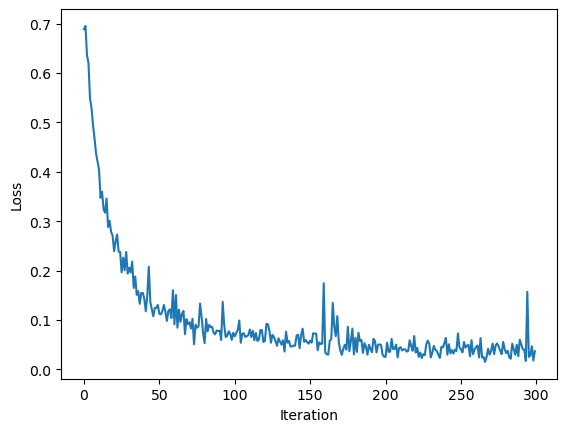

In [22]:
# Plot the loss
plt.plot(loss_list)
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.title("Iterations vs Loss")
plt.show()

In [23]:
# Identify the first four misclassified samples using the validation data
validation_dataset[0][0].shape

/tmp/ipykernel_196/3876928197.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image=torch.load(self.all_files[idx])


torch.Size([3, 224, 224])

In [24]:
Softmax_fn=nn.Softmax(dim=-1)
count=0
number_of_samples=0
for x,y in validation_dataset:
    z = model(x.reshape(-1, 3, 224, 224))
    _, yhat = torch.max(z, 1)
    number_of_samples+=1
    if yhat!=y:
        print(f"Sample: {number_of_samples}")
        print(f"Actual value: {y.item()}")
        print(f"Predicted value: {yhat.item()}")
        print(f"Probability of class {yhat.item()} is {torch.max(Softmax_fn(z)).item()}")
        count+=1
    if count>=4:
        break

/tmp/ipykernel_196/3876928197.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image=torch.load(self.all_files[idx])


Sample: 50
Actual value: 0
Predicted value: 1
Probability of class 1 is 0.814399242401123
Sample: 472
Actual value: 0
Predicted value: 1
Probability of class 1 is 0.6686035990715027
Sample: 758
Actual value: 0
Predicted value: 1
Probability of class 1 is 0.6877449154853821
Sample: 876
Actual value: 0
Predicted value: 1
Probability of class 1 is 0.7844752669334412


Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">MIT License</a>.
